In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install Sastrawi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 14.1 MB/s eta 0:00:00


In [ ]:
#do all the needed imports
import pandas as pd
import json
import re
import random
import string
import collections
from collections import Counter
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords #stopwords
stopwords_indonesia = stopwords.words('indonesian')
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory #sastrawi
factory = StemmerFactory()
stemmer = factory.create_stemmer()
from nltk.tokenize import TweetTokenizer, word_tokenize #tokenize
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.datasets import make_classification
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_fscore_support, precision_recall_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.spatial as sp
import tensorflow_hub as hub
import tensorflow as tf
import abc
from typing import List
from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Active Learning Dataset 1

In [ ]:
data = pd.DataFrame()
data =pd.read_csv("/content/drive/MyDrive/Data Skripsi/clean_data_dataset1_v2.csv")
data

,label,text
0,negatif,metafora konyol kubur konon hantu ghost buster...
1,positif,positive rate populasi juta statistik juta dud...
2,positif,jalan pandemi juli februari tingkat pesat janu...
3,positif,ayo ikut talkshow judul pandemi ubah riset sai...
4,positif,pandemi ubah riset sains via tinggal partisipa...
...,...,...
4268,positif,dirgahayu ikat hakim ikahi soliditas ikahi awa...
4269,positif,pandemi jaksa agung burhanuddin terobos instru...
4270,positif,ketua bidang fatwa mui asrorun niam saleh laks...
4271,positif,presiden orang terima loh moga bebas aamiin as...


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4273 entries, 0 to 4272
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   4273 non-null   object
 1   text    4272 non-null   object
dtypes: object(2)
memory usage: 66.9+ KB


In [ ]:
#check missing value
print(data.isnull().sum())

label    0
text     1
dtype: int64


In [ ]:
#hapus baris yang kosong
data = data.dropna(axis=0)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4272 entries, 0 to 4272
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   4272 non-null   object
 1   text    4272 non-null   object
dtypes: object(2)
memory usage: 100.1+ KB


In [ ]:
data.label.value_counts()

positif    3249
negatif    1023
Name: label, dtype: int64

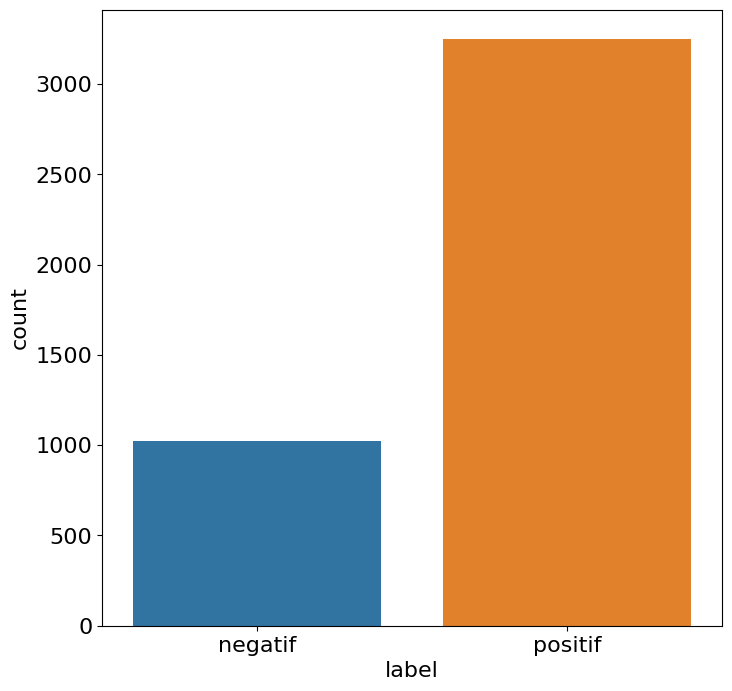

In [ ]:
plt.figure(figsize = (8, 8))
sns.countplot(x = 'label', data = data)
plt.show()

In [ ]:
#split data into train and test
train, test = train_test_split(data, test_size=0.3, random_state=42)
# let's select some sample from train set
initial_train, pool =  train_test_split(train, test_size=0.95, random_state=42)
initial_train.reset_index(drop=True, inplace=True)
pool.reset_index(drop=True, inplace=True)

In [ ]:
class QueryStrategy(abc.ABC):
    @abc.abstractmethod
    def selection(self, *args, **kwargs):
        raise NotImplementedError


In [ ]:
class RandomSelection(QueryStrategy):
    """
    Random selection strategy.

    Parameters:
    probs: int - number of data samples in unlabelled pool
    num_samples: int - number of samples which we want to select

    Returns:
    List[int]: List of data samples indexes which will be selected.
    """
    def selection(self, probs: np.ndarray, num_samples: int) -> List[int]:
        if probs.shape[0] >= num_samples:
            selection = np.random.choice(probs.shape[0], num_samples, replace=False)
        else:
            selection = np.arange(probs.shape[0])
        return selection

In [ ]:
class MarginSelection(QueryStrategy):
    """
    Margin selection strategy.

    Parameters:
    probs: np.ndarray - predicted probabilities of the unlabelled pool
    num_samples: int - number of samples which we want to select

    Returns:
    List[int]: List of data samples indexes which will be selected.
    """
    def selection(self, probs: np.ndarray, num_samples:int) -> List[int]:
        rev = np.sort(probs, axis=1)[:, ::-1]
        values = rev[:, 0] - rev[:, 1]
        if len(probs) >= num_samples:
            selection = np.argsort(values)[:num_samples]
        else:
            selection = np.argsort(values)
        return selection

In [ ]:
class MostErrorBucketSelection(QueryStrategy):
    """
    Select from the specific range of the predicted probabilities, which contains the most amount of errors.

    Parameters:
    probs: np.ndarray - predicted probabilities of the unlabelled pool
    num_samples: int - number of samples which we want to select
    train: pd.Dataframe - train
    clf - classificator

    Returns:
    List[int]: List of data samples indexes which will be selected.
    """
    def selection(self, probs: np.ndarray, num_samples: int, train_: pd.DataFrame, clf):
        train_["probs"] = clf.predict_proba(train_["text"])[:, 1]
        train_["decile"] = pd.cut(train_["probs"], 10)
        train_["preds"] = clf.predict(train_["text"])
        train_["error"] = train_.apply(lambda x: 1 if x["preds"] != x["label"] else 0, axis=1)
        train_["num_errors"] = train_.groupby("decile")["error"].transform(lambda x: x.sum())
        error_inter = train_.iloc[train_["num_errors"].argmax()]["decile"]
        mask = np.array([True if a in error_inter else False for a in probs[:, 1]])
        selection = mask.argsort()[-num_samples:]
        return selection

In [ ]:
class EmbeddingSimilatitySelection(QueryStrategy):
    """
    Select from the samples which similar to particular class examples in already labelled data with deep embeddings.

    Parameters:
    embedder: np.ndarray - predicted probabilities of the unlabelled pool
    num_samples: int - number of samples which we want to select
    trn: pd.Dataframe - train dataset
    pl: pd.Dataframe - pool of unlabelled data

    Returns:
    List[int]: List of data samples indexes which will be selected.
    """
    def selection(self, embedder, num_samples: int, train_: pd.DataFrame, pool_: pd.DataFrame):
        matrix1 = embedder(train_.query("label=='spam'")["text"].values).numpy()
        matrix2 = embedder(pool_["text"].values).numpy()
        res = 1 - sp.distance.cdist(matrix1, matrix2, 'cosine')
        col_max = np.amax(res, axis=0)
        selected_indices = np.argsort(col_max)[-num_samples:]
        return selected_indices

## Accuracy

In [ ]:
from typing import Callable, List, Any
from sklearn.metrics import f1_score
import inspect


class ActiveLearner:
    def __init__(self, test: pd.DataFrame, initial_train:pd.DataFrame, pool:pd.DataFrame,
                 classifier, batch_size: int = 15):
        self.batch_size: int = batch_size
        self.test: pd.DataFrame = test # test set
        self.train: pd.DataFrame = initial_train.copy() # train set
        self.pool: pd.DataFrame = pool.copy() # unlabeled pool
        self.classifier = classifier # classifier
        self.classifier.fit(self.train["text"], self.train["label"]) # fitting the classifier on initial train set
        self.calculated_metrics: List[float] = list() #define a list where we will put metrics from every iteration
        # store the metrics on 0 iteration
        self.calculated_metrics.append(accuracy_score(self.test["label"],
                                                self.classifier.predict(self.test["text"])))

    def active_learning_cycle(self, iterations_num: int , selection_type: Any, embedder = None):
        for it in range(iterations_num):
            probs = self.classifier.predict_proba(self.pool["text"]) # make predictions on pool set
            args: List[str] = inspect.getfullargspec(selection_type.selection)[0]
            if len(args)==3:
                indexes = selection_type.selection(probs, self.batch_size) # get the indexes of data samples with query strategy
            elif embedder:
                indexes = selection_type.selection(embedder, self.batch_size, self.train, self.pool)
            else:
                indexes = selection_type.selection(probs, self.batch_size, self.train, self.classifier)
            new = self.pool[self.pool.index.isin(indexes)] # select data samples by indexes from pool
            self.train = pd.concat([self.train, new]) # as we already have labels, append labelled sample to train data
            self.train.reset_index(drop=True, inplace=True)
            self.pool.drop(indexes, inplace=True) # drop selected samples from ublabeled pool
            self.pool.reset_index(drop=True, inplace=True) # reset indexing
            self.classifier.fit(self.train["text"], self.train["label"]) # fit the classifier on updated train set
            preds = self.classifier.predict(self.test["text"]) # do the predictions on the test set
            self.calculated_metrics.append(accuracy_score(self.test["label"], preds)) # monitor choosen metric on test set

In [ ]:
# calculate possible amount of iterations with given batch_size
iterations_num = int(pool.shape[0]/42.4)
# specify the classifier
classifier = Pipeline(
    steps=[
        ("tfidf", TfidfVectorizer()),
        ('clf', LogisticRegression(random_state=42))])

# random sampling
random_cycle = ActiveLearner(test, initial_train, pool, classifier)
random_cycle.active_learning_cycle(iterations_num = iterations_num,
                                   selection_type = RandomSelection())

# margin sampling
margin_cycle = ActiveLearner(test, initial_train, pool, classifier)
margin_cycle.active_learning_cycle(iterations_num = iterations_num,selection_type = MarginSelection())

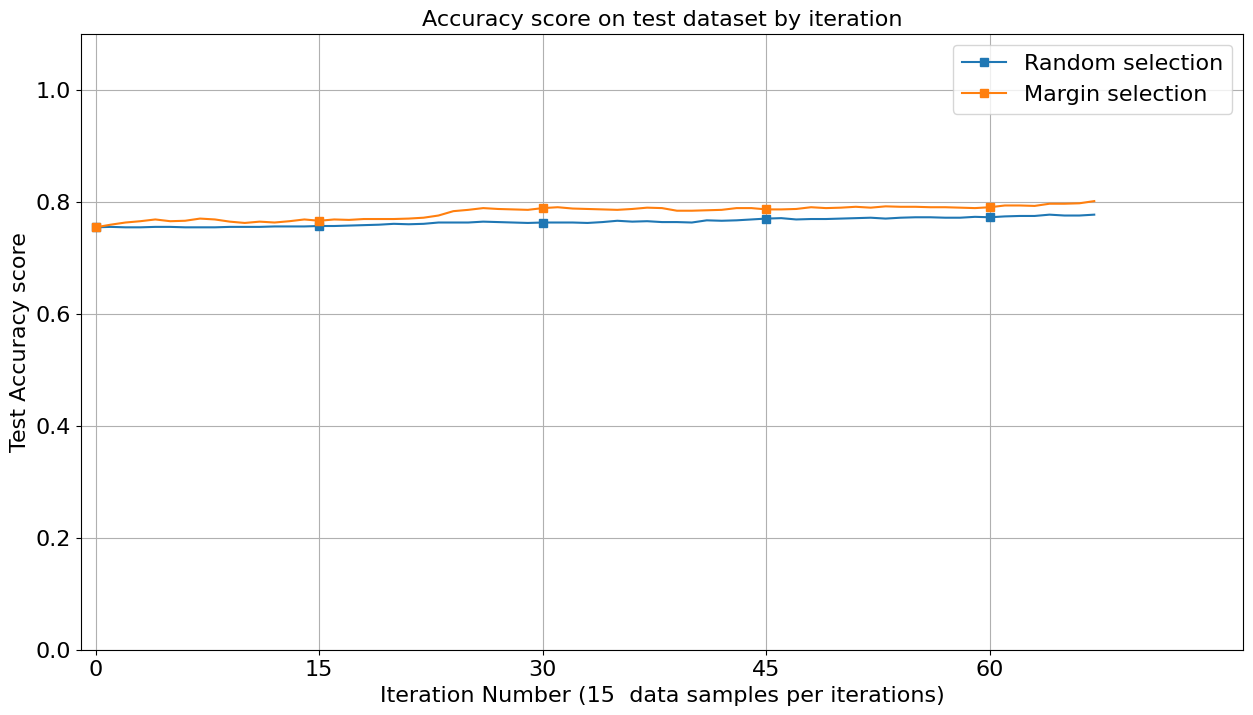

Data sampel ke - [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67] 
 mendapat nilai Accuracy = [0.7542901716068643, 0.7550702028081123, 0.7542901716068643, 0.7542901716068643, 0.7550702028081123, 0.7550702028081123, 0.7542901716068643, 0.7542901716068643, 0.7542901716068643, 0.7550702028081123, 0.7550702028081123, 0.7550702028081123, 0.7558502340093604, 0.7558502340093604, 0.7558502340093604, 0.7566302652106084, 0.7566302652106084, 0.7574102964118564, 0.7581903276131046, 0.7589703588143526, 0.7605304212168487, 0.7597503900156006, 0.7605304212168487, 0.7628705148205929, 0.7628705148205929, 0.7628705148205929, 0.7644305772230889, 0.7636505460218409, 0.7628705148205929, 0.7620904836193447, 0.7628705148205929, 0.7628705148205929, 0.7628705148205929, 0.7620904836193447, 0.7636505460218409, 0.765990639625585, 0.7644305772230889, 0.76521

In [ ]:
# result plot
import matplotlib.pyplot as plt

BIGGER_SIZE: int = 16
plt.figure(figsize=(15,8))
plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title=
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)

iterations = np.arange(0, iterations_num+1, 1)

plt.title ("Accuracy score on test dataset by iteration", fontsize=BIGGER_SIZE)
plt.ylabel("Test Accuracy score", fontsize=BIGGER_SIZE)
plt.ylim(0,1.1)
plt.xlim(-1,iterations_num+10)
plt.xticks(np.arange(0, iterations_num+1, 15))
plt.yticks(np.arange(0, 1.1, 0.2))
plt.xlabel("Iteration Number (15  data samples per iterations)")
plt.plot(iterations, random_cycle.calculated_metrics, label = "Random selection", marker='s', markevery=15)
plt.plot(iterations, margin_cycle.calculated_metrics, label = "Margin selection", marker='s', markevery=15)
#plt.plot(iterations, error_bucket_cycle.calculated_metrics, label = "Most errors interval selection", marker='o', markevery=10)
#plt.plot(iterations, embedder_cycle.calculated_metrics, label = "Text similarity selection", marker='o', markevery=10)
plt.grid(True)
plt.legend()
plt.show()
# 14 iteration for margin cycle
# 14 iteration for most error selection
# 20 iteration for embbeder query
print("Data sampel ke -", iterations, "\n mendapat nilai Accuracy =", random_cycle.calculated_metrics)
print("Data sampel ke -", iterations, "\n mendapat nilai Accuracy =", margin_cycle.calculated_metrics)

In [ ]:
#calculate possible amount of iterations with given batch_size
iterations_num = int(pool.shape[0]/32.6)
# specify the classifier
classifier = Pipeline(
    steps=[
        ("tfidf", TfidfVectorizer()),
        ('clf', RandomForestClassifier(random_state=42))])

#random sampling
random_cycle = ActiveLearner(test, initial_train, pool, classifier)
random_cycle.active_learning_cycle(iterations_num = iterations_num,
                                   selection_type = RandomSelection())

#margin sampling
margin_cycle = ActiveLearner(test, initial_train, pool, classifier)
margin_cycle.active_learning_cycle(iterations_num = iterations_num,selection_type = MarginSelection())


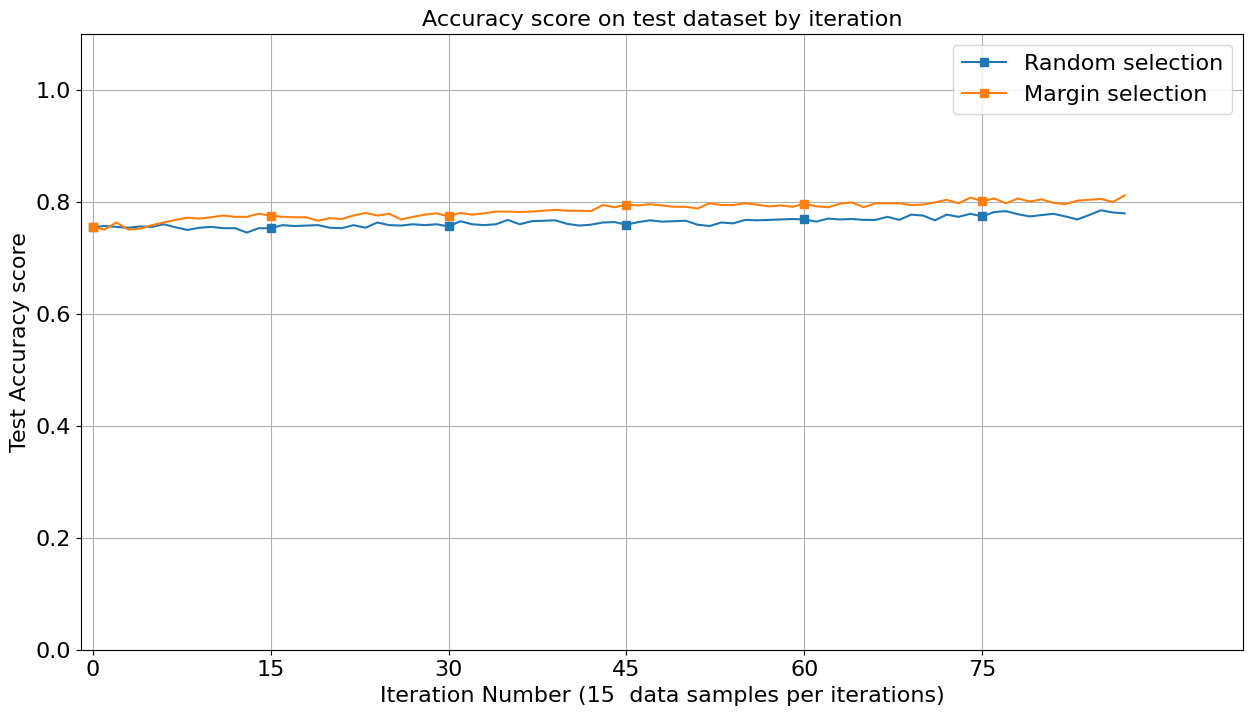

iterasi ke - [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87] mendapat nilai Accuracy = [0.7542901716068643, 0.7566302652106084, 0.7550702028081123, 0.7535101404056163, 0.7558502340093604, 0.7550702028081123, 0.7597503900156006, 0.7542901716068643, 0.749609984399376, 0.7535101404056163, 0.7550702028081123, 0.7527301092043682, 0.7527301092043682, 0.7449297971918877, 0.7527301092043682, 0.7527301092043682, 0.7581903276131046, 0.7566302652106084, 0.7574102964118564, 0.7581903276131046, 0.7535101404056163, 0.7527301092043682, 0.7581903276131046, 0.7535101404056163, 0.7628705148205929, 0.7581903276131046, 0.7574102964118564, 0.7597503900156006, 0.7581903276131046, 0.7597503900156006, 0.7558502340093604, 0.765210608424337, 0.7597503900156006, 0.7581903276131046, 0.75975039001

In [ ]:
#result plot
import matplotlib.pyplot as plt

BIGGER_SIZE: int = 16
plt.figure(figsize=(15,8))
plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title=
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)

iterations = np.arange(0, iterations_num+1, 1)

plt.title ("Accuracy score on test dataset by iteration", fontsize=BIGGER_SIZE)
plt.ylabel("Test Accuracy score", fontsize=BIGGER_SIZE)
plt.ylim(0,1.1)
plt.xlim(-1,iterations_num+10)
plt.xticks(np.arange(0, iterations_num+1, 15))
plt.yticks(np.arange(0, 1.1, 0.2))
plt.xlabel("Iteration Number (15  data samples per iterations)")
plt.plot(iterations, random_cycle.calculated_metrics, label = "Random selection", marker='s', markevery=15)
plt.plot(iterations, margin_cycle.calculated_metrics, label = "Margin selection", marker='s', markevery=15)
#plt.plot(iterations, error_bucket_cycle.calculated_metrics, label = "Most errors interval selection", marker='o', markevery=10)
#plt.plot(iterations, embedder_cycle.calculated_metrics, label = "Text similarity selection", marker='o', markevery=10)
plt.grid(True)
plt.legend()
plt.show()
# 14 iteration for margin cycle
# 14 iteration for most error selection
# 20 iteration for embbeder query
print("iterasi ke -", iterations, "mendapat nilai Accuracy =", random_cycle.calculated_metrics)
print(("iterasi ke -", iterations, "mendapat nilai Accuracy =", margin_cycle.calculated_metrics))

##F1-Score

In [ ]:
from typing import Callable, List, Any
from sklearn.metrics import f1_score
import inspect


class ActiveLearner:
    def __init__(self, test: pd.DataFrame, initial_train:pd.DataFrame, pool:pd.DataFrame,
                 classifier, batch_size: int = 15):
        self.batch_size: int = batch_size
        self.test: pd.DataFrame = test # test set
        self.train: pd.DataFrame = initial_train.copy() # train set
        self.pool: pd.DataFrame = pool.copy() # unlabeled pool
        self.classifier = classifier # classifier
        self.classifier.fit(self.train["text"], self.train["label"]) # fitting the classifier on initial train set
        self.calculated_metrics: List[float] = list() #define a list where we will put metrics from every iteration
        # store the metrics on 0 iteration
        self.calculated_metrics.append(f1_score(self.test["label"],
                                                self.classifier.predict(self.test["text"]),
                                                pos_label="positif"))

    def active_learning_cycle(self, iterations_num: int , selection_type: Any, embedder = None):
        for it in range(iterations_num):
            probs = self.classifier.predict_proba(self.pool["text"]) # make predictions on unlabelled pool
            args: List[str] = inspect.getfullargspec(selection_type.selection)[0]
            if len(args)==3:
                indexes = selection_type.selection(probs, self.batch_size) # get the indexes of data samples with query strategy
            elif embedder:
                indexes = selection_type.selection(embedder, self.batch_size, self.train, self.pool)
            else:
                indexes = selection_type.selection(probs, self.batch_size, self.train, self.classifier)
            new = self.pool[self.pool.index.isin(indexes)] # select data samples by indexes from pool
            self.train = pd.concat([self.train, new]) # as we already have labels, append labelled sample to train data
            self.train.reset_index(drop=True, inplace=True)
            self.pool.drop(indexes, inplace=True) # drop selected samples from ublabeled pool
            self.pool.reset_index(drop=True, inplace=True) # reset indexing
            self.classifier.fit(self.train["text"], self.train["label"]) # fit the classifier on updated train set
            preds = self.classifier.predict(self.test["text"]) # do the predictions on the test set
            self.calculated_metrics.append(f1_score(self.test["label"], preds, pos_label="positif")) # monitor choosen metric on test set

In [ ]:
# calculate possible amount of iterations with given batch_size
iterations_num = int(pool.shape[0]/39.4)
# specify the classifier
classifier = Pipeline(
    steps=[
        ("tfidf", TfidfVectorizer()),
        ('clf', LogisticRegression(random_state=42)),])

# random sampling
random_cycle = ActiveLearner(test, initial_train, pool, classifier)
random_cycle.active_learning_cycle(iterations_num = iterations_num,
                                   selection_type = RandomSelection())

# # margin sampling
margin_cycle = ActiveLearner(test, initial_train, pool, classifier)
margin_cycle.active_learning_cycle(iterations_num = iterations_num,selection_type = MarginSelection())

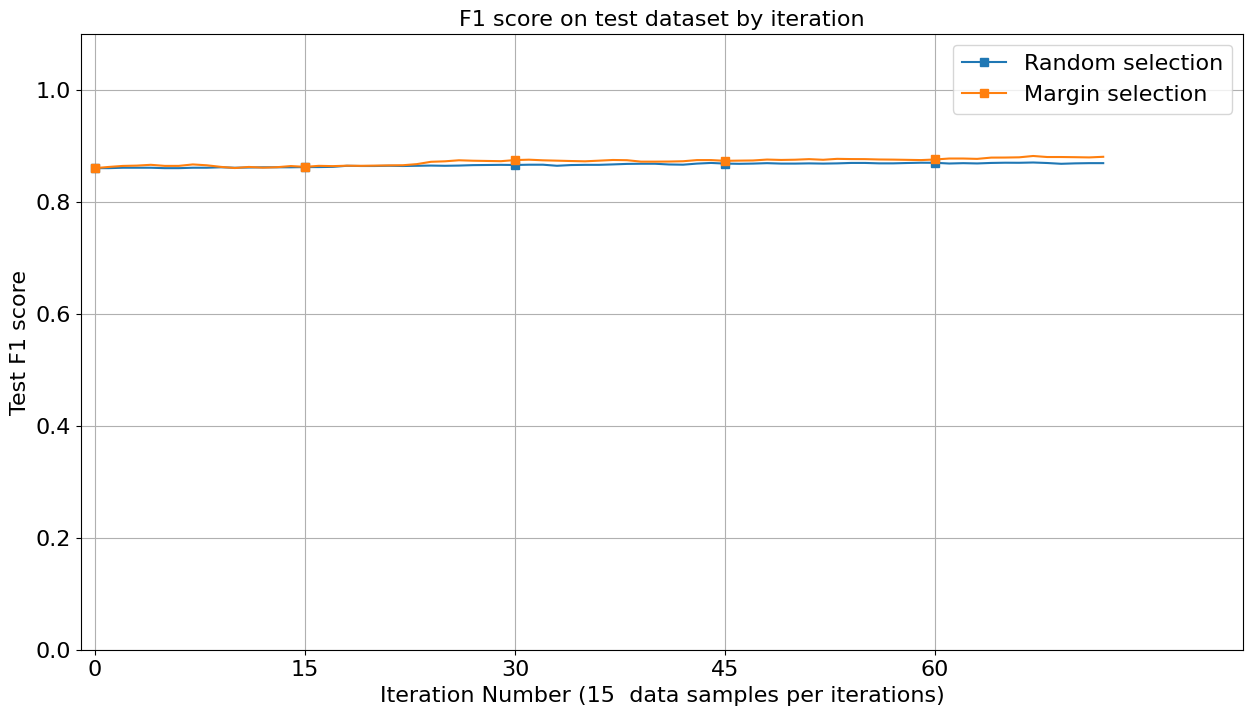

iterasi ke - [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72] mendapat nilai F1-score = [0.8599377501111605, 0.8599377501111605, 0.8607031597685804, 0.8607031597685804, 0.8607031597685804, 0.8599377501111605, 0.8599377501111605, 0.8607031597685804, 0.8607031597685804, 0.8614699331848552, 0.8607031597685804, 0.8610863757791629, 0.8614699331848552, 0.8614699331848552, 0.8614699331848552, 0.8618538324420677, 0.8618538324420677, 0.862238074008025, 0.8641644325290438, 0.8637784725323805, 0.8637784725323805, 0.8641644325290438, 0.8637784725323805, 0.8641644325290438, 0.8645507375949933, 0.8641644325290438, 0.8645507375949933, 0.8653243847874721, 0.8655913978494624, 0.8658591296545536, 0.8655913978494624, 0.8660994178235558, 0.8660994178235558, 0.8641864634692962, 0.8654708520179373, 0.8658591296545536, 0.865859129654553

In [ ]:
# result plot
import matplotlib.pyplot as plt

BIGGER_SIZE: int = 16
plt.figure(figsize=(15,8))
plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title=
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)

iterations = np.arange(0, iterations_num+1, 1)

plt.title ("F1 score on test dataset by iteration", fontsize=BIGGER_SIZE)
plt.ylabel("Test F1 score", fontsize=BIGGER_SIZE)
plt.ylim(0,1.1)
plt.xlim(-1,iterations_num+10)
plt.xticks(np.arange(0, iterations_num+1, 15))
plt.yticks(np.arange(0, 1.1, 0.2))
plt.xlabel("Iteration Number (15  data samples per iterations)")
plt.plot(iterations, random_cycle.calculated_metrics, label = "Random selection", marker='s', markevery=15)
plt.plot(iterations, margin_cycle.calculated_metrics, label = "Margin selection", marker='s', markevery=15)
#plt.plot(iterations, error_bucket_cycle.calculated_metrics, label = "Most errors interval selection", marker='o', markevery=10)
#plt.plot(iterations, embedder_cycle.calculated_metrics, label = "Text similarity selection", marker='o', markevery=10)
plt.grid(True)
plt.legend()
plt.show()
# 14 iteration for margin cycle
# 14 iteration for most error selection
# 20 iteration for embbeder query
print("iterasi ke -", iterations, "mendapat nilai F1-score =", random_cycle.calculated_metrics)
print(("iterasi ke -", iterations, "mendapat nilai F1-score =", margin_cycle.calculated_metrics))

In [ ]:
# calculate possible amount of iterations with given batch_size
iterations_num = int(pool.shape[0]/28)
# specify the classifier
classifier = Pipeline(
    steps=[
        ("tfidf", TfidfVectorizer()),
        ('clf', RandomForestClassifier( random_state =42))])

# random sampling
random_cycle = ActiveLearner(test, initial_train, pool, classifier)
random_cycle.active_learning_cycle(iterations_num = iterations_num,
                                   selection_type = RandomSelection())

# # margin sampling
margin_cycle = ActiveLearner(test, initial_train, pool, classifier)
margin_cycle.active_learning_cycle(iterations_num = iterations_num,selection_type = MarginSelection())

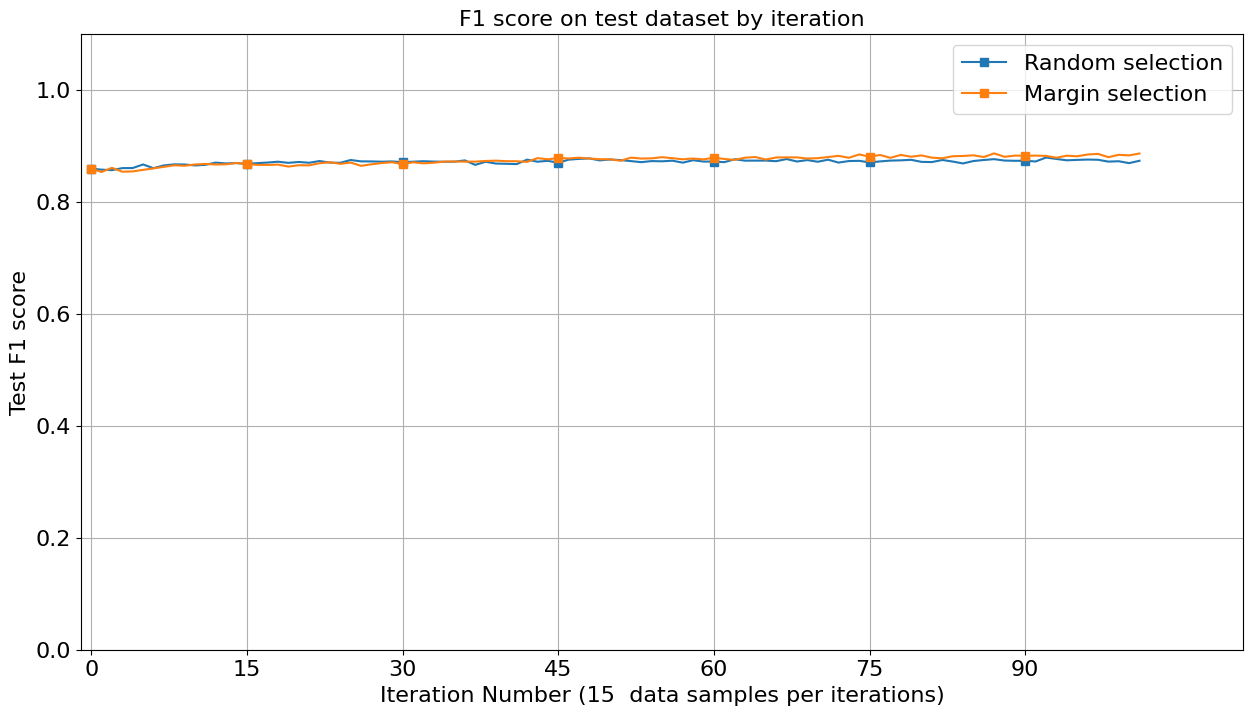

iterasi ke - [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101] mendapat nilai F1-score = [0.8589341692789968, 0.8572714993246285, 0.8563685636856369, 0.8600000000000001, 0.8601271571298819, 0.8665148063781322, 0.8598813327247833, 0.8647912885662432, 0.8667271078875792, 0.8665148063781322, 0.8647912885662432, 0.8658759124087592, 0.8698412698412699, 0.8683729433272396, 0.8689717925386715, 0.8677007299270073, 0.8688899040657835, 0.86996336996337, 0.8714416896235079, 0.869406392694064, 0.8709823449524673, 0.8695652173913044, 0.8726436781609196, 0.8698441796516957, 0.8694852941176469, 0.8744827586206897, 0.8720770288858322, 0.871959

In [ ]:
# result plot
import matplotlib.pyplot as plt

BIGGER_SIZE: int = 16
plt.figure(figsize=(15,8))
plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title=
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)

iterations = np.arange(0, iterations_num+1, 1)

plt.title ("F1 score on test dataset by iteration", fontsize=BIGGER_SIZE)
plt.ylabel("Test F1 score", fontsize=BIGGER_SIZE)
plt.ylim(0,1.1)
plt.xlim(-1,iterations_num+10)
plt.xticks(np.arange(0, iterations_num+1, 15))
plt.yticks(np.arange(0, 1.1, 0.2))
plt.xlabel("Iteration Number (15  data samples per iterations)")
plt.plot(iterations, random_cycle.calculated_metrics, label = "Random selection", marker='s', markevery=15)
plt.plot(iterations, margin_cycle.calculated_metrics, label = "Margin selection", marker='s', markevery=15)
#plt.plot(iterations, error_bucket_cycle.calculated_metrics, label = "Most errors interval selection", marker='o', markevery=10)
#plt.plot(iterations, embedder_cycle.calculated_metrics, label = "Text similarity selection", marker='o', markevery=10)
plt.grid(True)
plt.legend()
plt.show()
# 14 iteration for margin cycle
# 14 iteration for most error selection
# 20 iteration for embbeder query
print("iterasi ke -", iterations, "mendapat nilai F1-score =", random_cycle.calculated_metrics)
print(("iterasi ke -", iterations, "mendapat nilai F1-score =", margin_cycle.calculated_metrics))

# Active Learning Dataset 2

In [ ]:
data = pd.DataFrame()
data = pd.read_csv('/content/drive/MyDrive/Data Skripsi/clean_data_dataset2.csv')
data =data.rename(columns={'Tweet': 'text'})
data

,label,text
0,negatif,lagu bosan save
1,negatif,lanjut diam erti sama libat hati
2,positif,doa rezeki putus inna haa zaa larizquna maa la...
3,positif,makasih ntar hasil sisa
4,negatif,faham jenis orang malaysia ret sangkut hose ge...
...,...,...
5051,negatif,pelik tengok orang zaman main ria effort last ...
5052,positif,banding hidup hidup orang milik karunia
5053,positif,apa laku apa salah temu maaf hati botkece
5054,positif,hafal


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5056 entries, 0 to 5055
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   5056 non-null   object
 1   text    5055 non-null   object
dtypes: object(2)
memory usage: 79.1+ KB


In [ ]:
#check missing value
print(data.isnull().sum())

label    0
text     1
dtype: int64


In [ ]:
#hapus baris yang kosong
data = data.dropna(axis=0)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5055 entries, 0 to 5055
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   5055 non-null   object
 1   text    5055 non-null   object
dtypes: object(2)
memory usage: 118.5+ KB


In [ ]:
data.label.value_counts()

negatif    2638
positif    2417
Name: label, dtype: int64

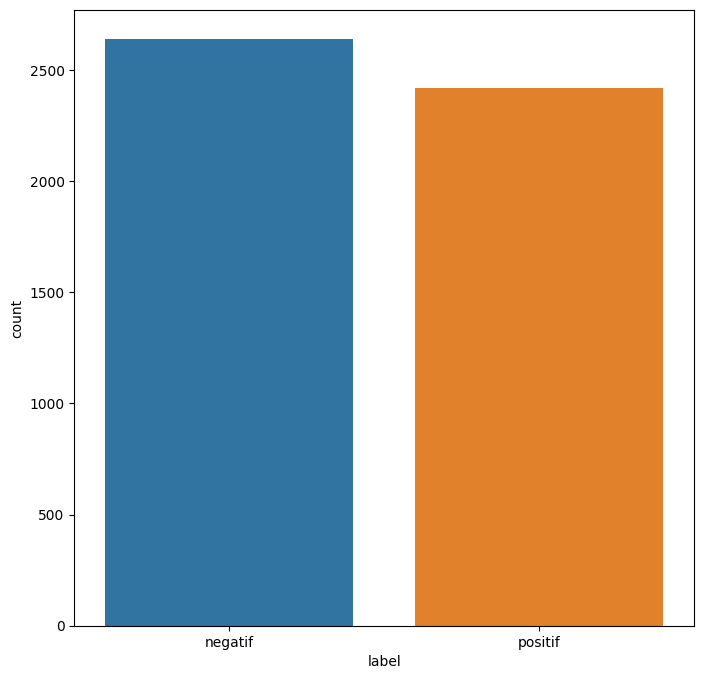

In [ ]:
plt.figure(figsize = (8, 8))
sns.countplot(x = 'label', data = data)
plt.show()

In [ ]:
#split data into train and test
train, test = train_test_split(data, test_size=0.2, random_state=42)
# let's select some sample from train set
initial_train, pool =  train_test_split(train, test_size=0.95, random_state=42)
initial_train.reset_index(drop=True, inplace=True)
pool.reset_index(drop=True, inplace=True)

## Accuracy

In [ ]:
from typing import Callable, List, Any
from sklearn.metrics import f1_score
import inspect


class ActiveLearner:
    def __init__(self, test: pd.DataFrame, initial_train:pd.DataFrame, pool:pd.DataFrame,
                 classifier, batch_size: int = 15):
        self.batch_size: int = batch_size
        self.test: pd.DataFrame = test # test set
        self.train: pd.DataFrame = initial_train.copy() # train set
        self.pool: pd.DataFrame = pool.copy() # unlabeled pool
        self.classifier = classifier # classifier
        self.classifier.fit(self.train["text"], self.train["label"]) # fitting the classifier on initial train set
        self.calculated_metrics: List[float] = list() #define a list where we will put metrics from every iteration
        # store the metrics on 0 iteration
        self.calculated_metrics.append(accuracy_score(self.test["label"],
                                                self.classifier.predict(self.test["text"])))

    def active_learning_cycle(self, iterations_num: int , selection_type: Any, embedder = None):
        for it in range(iterations_num):
            probs = self.classifier.predict_proba(self.pool["text"]) # make predictions on unlabelled pool
            args: List[str] = inspect.getfullargspec(selection_type.selection)[0]
            if len(args)==3:
                indexes = selection_type.selection(probs, self.batch_size) # get the indexes of data samples with query strategy
            elif embedder:
                indexes = selection_type.selection(embedder, self.batch_size, self.train, self.pool)
            else:
                indexes = selection_type.selection(probs, self.batch_size, self.train, self.classifier)
            new = self.pool[self.pool.index.isin(indexes)] # select data samples by indexes from pool
            self.train = pd.concat([self.train, new]) # as we already have labels, append labelled sample to train data
            self.train.reset_index(drop=True, inplace=True)
            self.pool.drop(indexes, inplace=True) # drop selected samples from ublabeled pool
            self.pool.reset_index(drop=True, inplace=True) # reset indexing
            self.classifier.fit(self.train["text"], self.train["label"]) # fit the classifier on updated train set
            preds = self.classifier.predict(self.test["text"]) # do the predictions on the test set
            self.calculated_metrics.append(accuracy_score(self.test["label"], preds)) # monitor choosen metric on test set

In [ ]:
# calculate possible amount of iterations with given batch_size
iterations_num = int(pool.shape[0]/18.7)
# specify the classifier
classifier = Pipeline(
    steps=[
        ("tfidf", TfidfVectorizer()),
        ('clf', LogisticRegression(random_state=42))])

# random sampling
random_cycle = ActiveLearner(test, initial_train, pool, classifier)
random_cycle.active_learning_cycle(iterations_num = iterations_num,
                                   selection_type = RandomSelection())

#margin sampling
margin_cycle = ActiveLearner(test, initial_train, pool, classifier)
margin_cycle.active_learning_cycle(iterations_num = iterations_num,selection_type = MarginSelection())

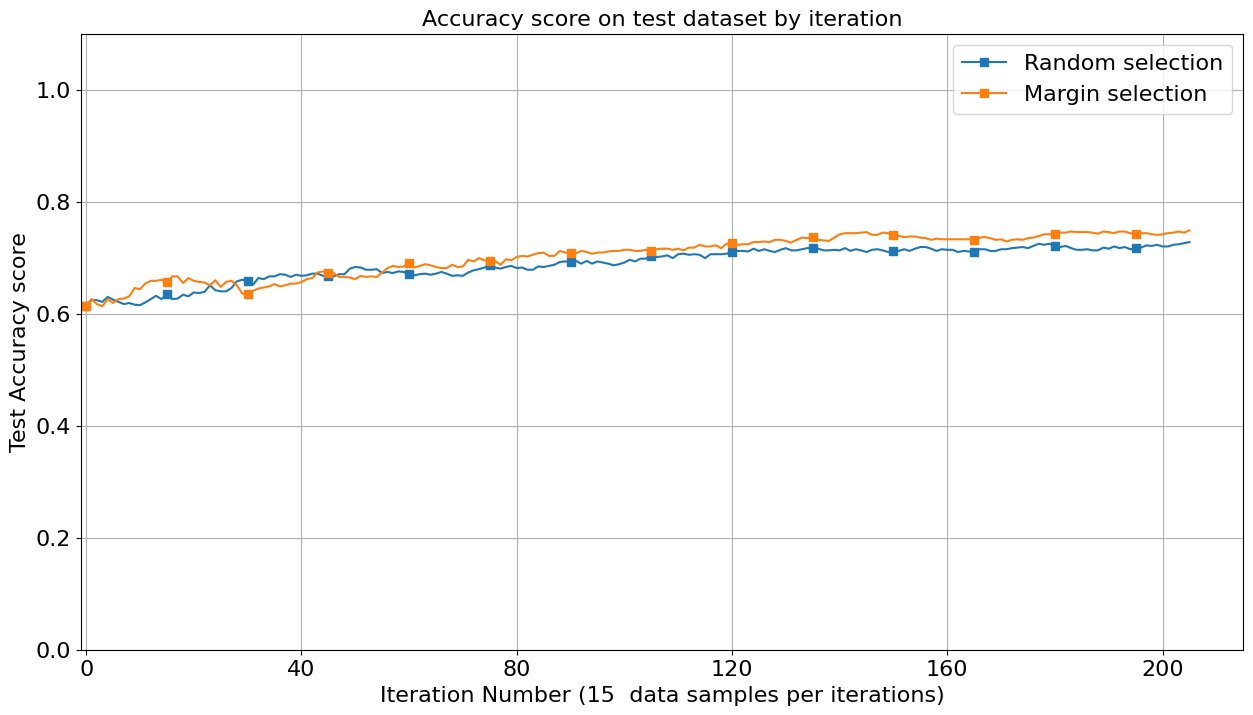

iterasi ke - [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205] mendapat nilai Accuracy = [0.6142433234421365, 0.6241345202769535, 0.6241345202769535, 0.6211671612265084, 0.6300692383778437, 0.6251236399604352, 0.6

In [ ]:
# result plot
import matplotlib.pyplot as plt

BIGGER_SIZE: int = 16
plt.figure(figsize=(15,8))
plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title=
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)

iterations = np.arange(0, iterations_num+1, 1)

plt.title ("Accuracy score on test dataset by iteration", fontsize=BIGGER_SIZE)
plt.ylabel("Test Accuracy score", fontsize=BIGGER_SIZE)
plt.ylim(0,1.1)
plt.xlim(-1,iterations_num+10)
plt.xticks(np.arange(0, iterations_num+1, 40))
plt.yticks(np.arange(0, 1.1, 0.2))
plt.xlabel("Iteration Number (15  data samples per iterations)")
plt.plot(iterations, random_cycle.calculated_metrics, label = "Random selection", marker='s', markevery=15)
plt.plot(iterations, margin_cycle.calculated_metrics, label = "Margin selection", marker='s', markevery=15)
#plt.plot(iterations, error_bucket_cycle.calculated_metrics, label = "Most errors interval selection", marker='o', markevery=10)
#plt.plot(iterations, embedder_cycle.calculated_metrics, label = "Text similarity selection", marker='o', markevery=10)
plt.grid(True)
plt.legend()
plt.show()
# 14 iteration for margin cycle
# 14 iteration for most error selection
# 20 iteration for embbeder query
print("iterasi ke -", iterations, "mendapat nilai Accuracy =", random_cycle.calculated_metrics)
print(("iterasi ke -", iterations, "mendapat nilai Accuracy =", margin_cycle.calculated_metrics))

In [ ]:
# calculate possible amount of iterations with given batch_size
iterations_num = int(pool.shape[0]/24)
# specify the classifier
classifier = Pipeline(
    steps=[
        ("tfidf", TfidfVectorizer()),
        ('clf', RandomForestClassifier(random_state=42))])

#random sampling
random_cycle = ActiveLearner(test, initial_train, pool, classifier)
random_cycle.active_learning_cycle(iterations_num = iterations_num,
                                   selection_type = RandomSelection())

#margin sampling
margin_cycle = ActiveLearner(test, initial_train, pool, classifier)
margin_cycle.active_learning_cycle(iterations_num = iterations_num,selection_type = MarginSelection())


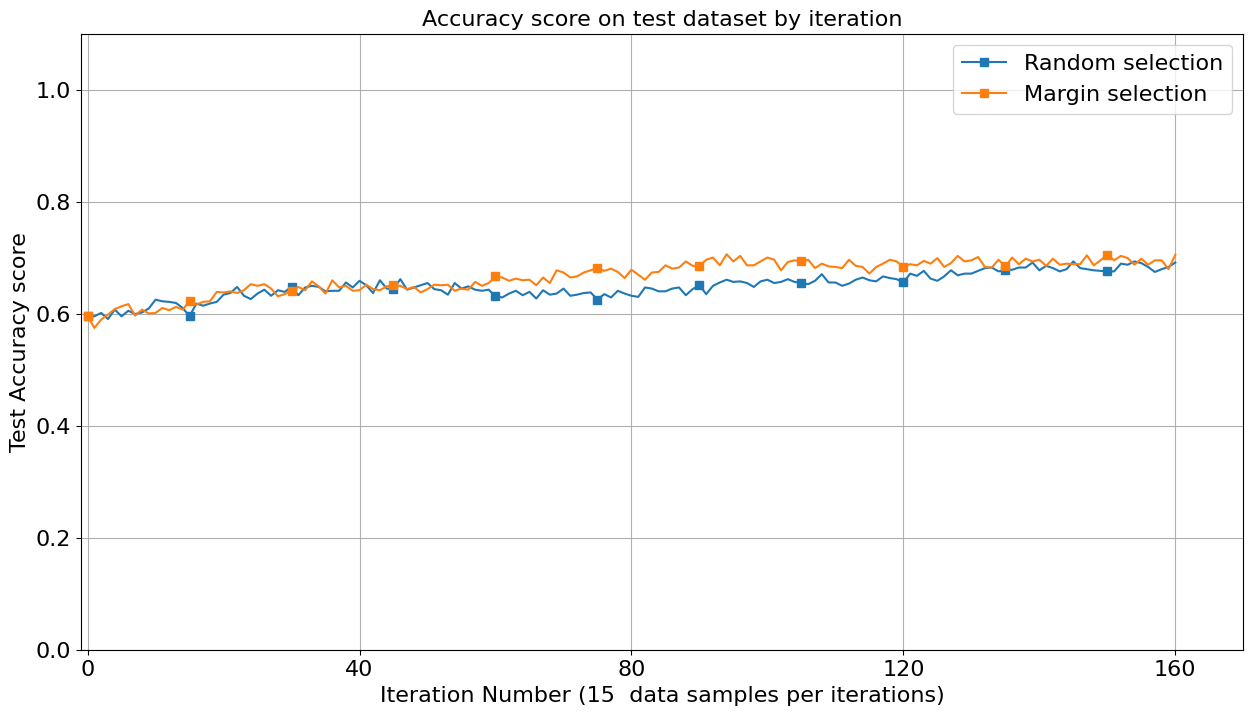

iterasi ke - [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160] mendapat nilai Accuracy = [0.5954500494559841, 0.5954500494559841, 0.6013847675568744, 0.5905044510385756, 0.6073194856577646, 0.5954500494559841, 0.6053412462908012, 0.599406528189911, 0.6023738872403561, 0.609297725024728, 0.6251236399604352, 0.6221562809099901, 0.6211671612265084, 0.619188921859545, 0.6102868447082097, 0.5954500

In [ ]:
# result plot
import matplotlib.pyplot as plt

BIGGER_SIZE: int = 16
plt.figure(figsize=(15,8))
plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title=
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)

iterations = np.arange(0, iterations_num+1, 1)

plt.title ("Accuracy score on test dataset by iteration", fontsize=BIGGER_SIZE)
plt.ylabel("Test Accuracy score", fontsize=BIGGER_SIZE)
plt.ylim(0,1.1)
plt.xlim(-1,iterations_num+10)
plt.xticks(np.arange(0, iterations_num+1, 40))
plt.yticks(np.arange(0, 1.1, 0.2))
plt.xlabel("Iteration Number (15  data samples per iterations)")
plt.plot(iterations, random_cycle.calculated_metrics, label = "Random selection", marker='s', markevery=15)
plt.plot(iterations, margin_cycle.calculated_metrics, label = "Margin selection", marker='s', markevery=15)
#plt.plot(iterations, error_bucket_cycle.calculated_metrics, label = "Most errors interval selection", marker='o', markevery=10)
#plt.plot(iterations, embedder_cycle.calculated_metrics, label = "Text similarity selection", marker='o', markevery=10)
plt.grid(True)
plt.legend()
plt.show()
# 14 iteration for margin cycle
# 14 iteration for most error selection
# 20 iteration for embbeder query
print("iterasi ke -", iterations, "mendapat nilai Accuracy =", random_cycle.calculated_metrics)
print(("iterasi ke -", iterations, "mendapat nilai Accuracy =", margin_cycle.calculated_metrics))

## F1-Score

In [ ]:
from typing import Callable, List, Any
from sklearn.metrics import f1_score
import inspect


class ActiveLearner:
    def __init__(self, test: pd.DataFrame, initial_train:pd.DataFrame, pool:pd.DataFrame,
                 classifier, batch_size: int = 15):
        self.batch_size: int = batch_size
        self.test: pd.DataFrame = test # test set
        self.train: pd.DataFrame = initial_train.copy() # train set
        self.pool: pd.DataFrame = pool.copy() # unlabeled pool
        self.classifier = classifier # classifier
        self.classifier.fit(self.train["text"], self.train["label"]) # fitting the classifier on initial train set
        self.calculated_metrics: List[float] = list() #define a list where we will put metrics from every iteration
        # store the metrics on 0 iteration
        self.calculated_metrics.append(f1_score(self.test["label"],
                                                self.classifier.predict(self.test["text"]),
                                                pos_label="negatif"))

    def active_learning_cycle(self, iterations_num: int , selection_type: Any, embedder = None):
        for it in range(iterations_num):
            probs = self.classifier.predict_proba(self.pool["text"]) # make predictions on unlabelled pool
            args: List[str] = inspect.getfullargspec(selection_type.selection)[0]
            if len(args)==3:
                indexes = selection_type.selection(probs, self.batch_size) # get the indexes of data samples with query strategy
            elif embedder:
                indexes = selection_type.selection(embedder, self.batch_size, self.train, self.pool)
            else:
                indexes = selection_type.selection(probs, self.batch_size, self.train, self.classifier)
            new = self.pool[self.pool.index.isin(indexes)] # select data samples by indexes from pool
            self.train = pd.concat([self.train, new]) # as we already have labels, append labelled sample to train data
            self.train.reset_index(drop=True, inplace=True)
            self.pool.drop(indexes, inplace=True) # drop selected samples from ublabeled pool
            self.pool.reset_index(drop=True, inplace=True) # reset indexing
            self.classifier.fit(self.train["text"], self.train["label"]) # fit the classifier on updated train set
            preds = self.classifier.predict(self.test["text"]) # do the predictions on the test set
            self.calculated_metrics.append(f1_score(self.test["label"], preds, pos_label="negatif")) # monitor choosen metric on test set

In [ ]:
# calculate possible amount of iterations with given batch_size
iterations_num = int(pool.shape[0]/18.7)
# specify the classifier
classifier = Pipeline(
    steps=[
        ("tfidf", TfidfVectorizer()),
        ('clf', LogisticRegression(random_state=42)),])

# random sampling
random_cycle = ActiveLearner(test, initial_train, pool, classifier)
random_cycle.active_learning_cycle(iterations_num = iterations_num,
                                   selection_type = RandomSelection())

# # margin sampling
margin_cycle = ActiveLearner(test, initial_train, pool, classifier)
margin_cycle.active_learning_cycle(iterations_num = iterations_num,selection_type = MarginSelection())

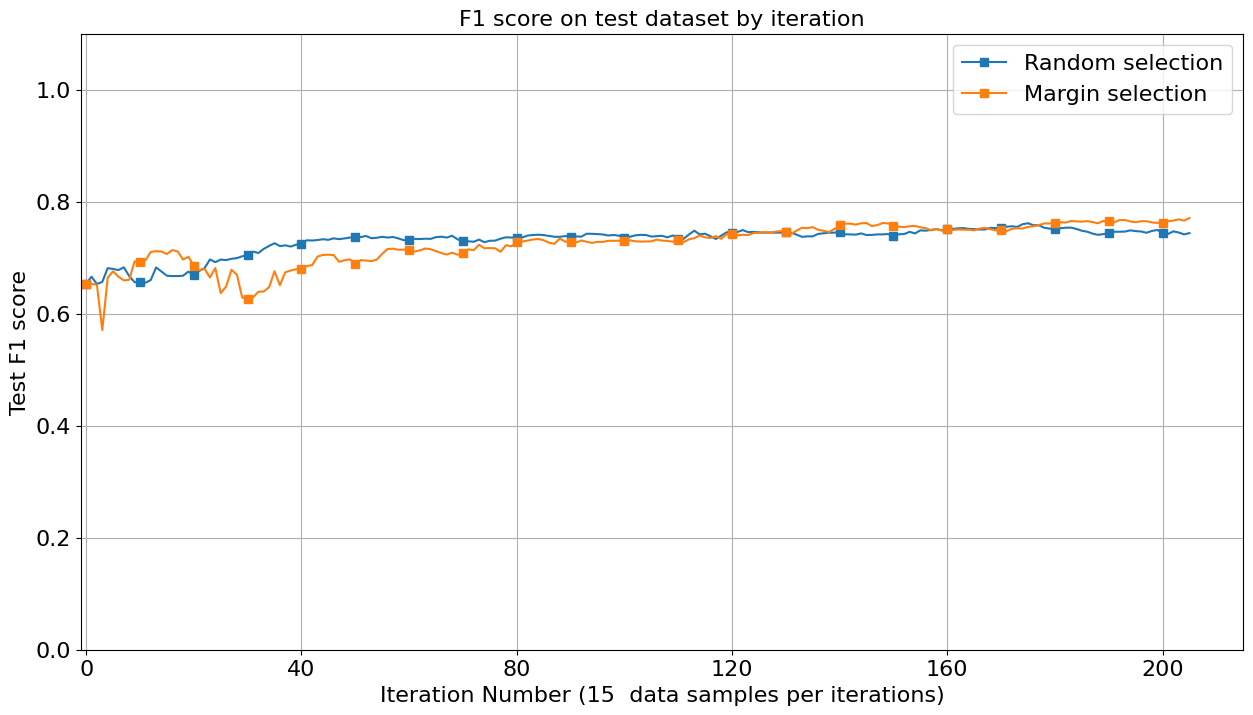

iterasi ke - [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205] mendapat nilai F1-score = [0.6536412078152752, 0.6660854402789887, 0.6529884032114185, 0.6568965517241379, 0.6813725490196078, 0.68, 0.677966101694915

In [ ]:
# result plot
import matplotlib.pyplot as plt

BIGGER_SIZE: int = 16
plt.figure(figsize=(15,8))
plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title=
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)

iterations = np.arange(0, iterations_num+1, 1)

plt.title ("F1 score on test dataset by iteration", fontsize=BIGGER_SIZE)
plt.ylabel("Test F1 score", fontsize=BIGGER_SIZE)
plt.ylim(0,1.1)
plt.xlim(-1,iterations_num+10)
plt.xticks(np.arange(0, iterations_num+1, 40))
plt.yticks(np.arange(0, 1.1, 0.2))
plt.xlabel("Iteration Number (15  data samples per iterations)")
plt.plot(iterations, random_cycle.calculated_metrics, label = "Random selection", marker='s', markevery=10)
plt.plot(iterations, margin_cycle.calculated_metrics, label = "Margin selection", marker='s', markevery=10)
#plt.plot(iterations, error_bucket_cycle.calculated_metrics, label = "Most errors interval selection", marker='o', markevery=10)
#plt.plot(iterations, embedder_cycle.calculated_metrics, label = "Text similarity selection", marker='o', markevery=10)
plt.grid(True)
plt.legend()
plt.show()
# 14 iteration for margin cycle
# 14 iteration for most error selection
# 20 iteration for embbeder query
print("iterasi ke -", iterations, "mendapat nilai F1-score =", random_cycle.calculated_metrics)
print(("iterasi ke -", iterations, "mendapat nilai F1-score =", margin_cycle.calculated_metrics))

In [ ]:
# calculate possible amount of iterations with given batch_size
iterations_num = int(pool.shape[0]/16.5)
# specify the classifier
classifier = Pipeline(
    steps=[
        ("tfidf", TfidfVectorizer()),
        ('clf', RandomForestClassifier( random_state =42))])

# random sampling
random_cycle = ActiveLearner(test, initial_train, pool, classifier)
random_cycle.active_learning_cycle(iterations_num = iterations_num,
                                   selection_type = RandomSelection())

# # margin sampling
margin_cycle = ActiveLearner(test, initial_train, pool, classifier)
margin_cycle.active_learning_cycle(iterations_num = iterations_num,selection_type = MarginSelection())

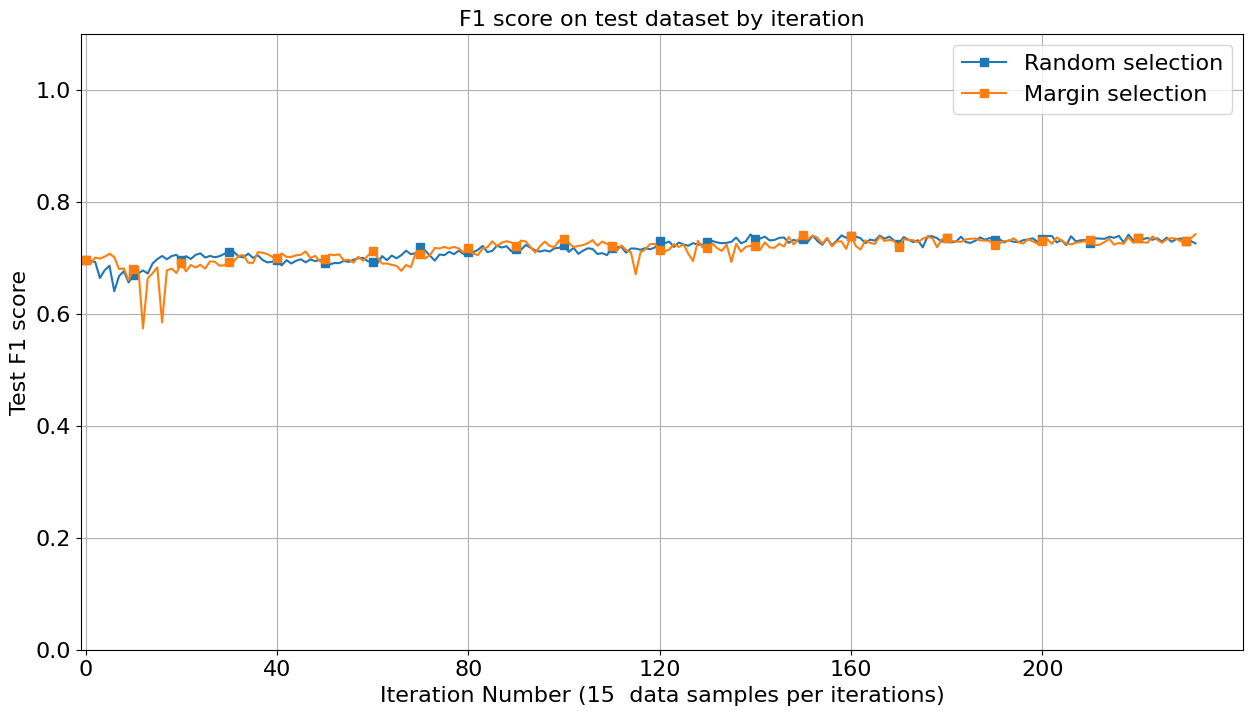

iterasi ke - [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232] mendapat nilai F1-score = [0.695910780669

In [ ]:
# result plot
import matplotlib.pyplot as plt

BIGGER_SIZE: int = 16
plt.figure(figsize=(15,8))
plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title=
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)

iterations = np.arange(0, iterations_num+1, 1)

plt.title ("F1 score on test dataset by iteration", fontsize=BIGGER_SIZE)
plt.ylabel("Test F1 score", fontsize=BIGGER_SIZE)
plt.ylim(0,1.1)
plt.xlim(-1,iterations_num+10)
plt.xticks(np.arange(0, iterations_num+1, 40))
plt.yticks(np.arange(0, 1.1, 0.2))
plt.xlabel("Iteration Number (15  data samples per iterations)")
plt.plot(iterations, random_cycle.calculated_metrics, label = "Random selection", marker='s', markevery=10)
plt.plot(iterations, margin_cycle.calculated_metrics, label = "Margin selection", marker='s', markevery=10)
#plt.plot(iterations, error_bucket_cycle.calculated_metrics, label = "Most errors interval selection", marker='o', markevery=10)
#plt.plot(iterations, embedder_cycle.calculated_metrics, label = "Text similarity selection", marker='o', markevery=10)
plt.grid(True)
plt.legend()
plt.show()
# 14 iteration for margin cycle
# 14 iteration for most error selection
# 20 iteration for embbeder query
print("iterasi ke -", iterations, "mendapat nilai F1-score =", random_cycle.calculated_metrics)
print(("iterasi ke -", iterations, "mendapat nilai F1-score =", margin_cycle.calculated_metrics))

# Passive Learning Dataset 2 RL RF


In [ ]:
data = pd.DataFrame()
data = pd.read_csv('/content/drive/MyDrive/Data Skripsi/clean_data_dataset2.csv')
data

,label,Tweet
0,negatif,lagu bosan save
1,negatif,lanjut diam erti sama libat hati
2,positif,doa rezeki putus inna haa zaa larizquna maa la...
3,positif,makasih ntar hasil sisa
4,negatif,faham jenis orang malaysia ret sangkut hose ge...
...,...,...
5051,negatif,pelik tengok orang zaman main ria effort last ...
5052,positif,banding hidup hidup orang milik karunia
5053,positif,apa laku apa salah temu maaf hati botkece
5054,positif,hafal


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5056 entries, 0 to 5055
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   5056 non-null   object
 1   Tweet   5055 non-null   object
dtypes: object(2)
memory usage: 79.1+ KB


In [ ]:
#check missing value
print(data.isnull().sum())

label    0
Tweet    1
dtype: int64


In [ ]:
#hapus baris yang kosong
data = data.dropna(axis=0)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5055 entries, 0 to 5055
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   5055 non-null   object
 1   Tweet   5055 non-null   object
dtypes: object(2)
memory usage: 118.5+ KB


In [ ]:
data.label.value_counts()

negatif    2638
positif    2417
Name: label, dtype: int64

In [ ]:
# title Feature Extraction: TF-IDF Model
tfidf = TfidfVectorizer( ngram_range=(1,3), analyzer='char')
x = tfidf.fit_transform(data['Tweet'])
y = data['label']
x.shape

(5055, 7026)

In [ ]:
# Splitting the dataset into the Training set and Test set
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.20, random_state = 42)

In [ ]:
#Logistic Regression
log = LogisticRegression(random_state=42)
#ovr = OneVsRestClassifier(log)
log.fit(x_train, y_train)
y_pred = log.predict(x_test)

In [ ]:
#Making the Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)
print("\n")
print(classification_report(y_test,y_pred))

print("\n")

log_accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %f' % log_accuracy)

log_precision = precision_score(y_test, y_pred, pos_label='negatif')
print('Precision: %f' % log_precision)

log_recall = recall_score(y_test, y_pred, pos_label='negatif')
print('Recall: %f' % log_recall)

log_f1_score = f1_score(y_test, y_pred, pos_label='negatif')
print('F1 Score: %f' % log_f1_score)

[[422 111]
 [168 310]]


              precision    recall  f1-score   support

     negatif       0.72      0.79      0.75       533
     positif       0.74      0.65      0.69       478

    accuracy                           0.72      1011
   macro avg       0.73      0.72      0.72      1011
weighted avg       0.73      0.72      0.72      1011



Accuracy: 0.724036
Precision: 0.715254
Recall: 0.791745
F1 Score: 0.751558


In [ ]:
#Random Forest
rf = RandomForestClassifier(random_state=42)
#ovr = OneVsRestClassifier(rf)
rf.fit(x_train, y_train)
y_pred = rf.predict(x_test)

In [ ]:
#Making the Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)
print("\n")
print(classification_report(y_test,y_pred))

print("\n")

rf_accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %f' % rf_accuracy)

rf_precision = precision_score(y_test, y_pred, pos_label='negatif')
print('Precision: %f' % rf_precision)

rf_recall = recall_score(y_test, y_pred, pos_label='negatif')
print('Recall: %f' % rf_recall)

rf_f1_score = f1_score(y_test, y_pred, pos_label='negatif')
print('F1 Score: %f' % rf_f1_score)


[[441  92]
 [240 238]]


              precision    recall  f1-score   support

     negatif       0.65      0.83      0.73       533
     positif       0.72      0.50      0.59       478

    accuracy                           0.67      1011
   macro avg       0.68      0.66      0.66      1011
weighted avg       0.68      0.67      0.66      1011



Accuracy: 0.671612
Precision: 0.647577
Recall: 0.827392
F1 Score: 0.726524


# Passive Learning Dataset 1 RL RF

In [ ]:
data = pd.DataFrame()
data =pd.read_csv("/content/drive/MyDrive/Data Skripsi/clean_data_dataset1_v2.csv")
data

,label,text
0,negatif,metafora konyol kubur konon hantu ghost buster...
1,positif,positive rate populasi juta statistik juta dud...
2,positif,jalan pandemi juli februari tingkat pesat janu...
3,positif,ayo ikut talkshow judul pandemi ubah riset sai...
4,positif,pandemi ubah riset sains via tinggal partisipa...
...,...,...
4268,positif,dirgahayu ikat hakim ikahi soliditas ikahi awa...
4269,positif,pandemi jaksa agung burhanuddin terobos instru...
4270,positif,ketua bidang fatwa mui asrorun niam saleh laks...
4271,positif,presiden orang terima loh moga bebas aamiin as...


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4273 entries, 0 to 4272
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   4273 non-null   object
 1   text    4272 non-null   object
dtypes: object(2)
memory usage: 66.9+ KB


In [ ]:
#check missing value
print(data.isnull().sum())

label    0
text     1
dtype: int64


In [ ]:
#hapus baris yang kosong
data = data.dropna(axis=0)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4272 entries, 0 to 4272
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   4272 non-null   object
 1   text    4272 non-null   object
dtypes: object(2)
memory usage: 100.1+ KB


In [ ]:
data.label.value_counts()

positif    3249
negatif    1023
Name: label, dtype: int64

In [ ]:
#Feature Extraction: TF-IDF Model
tfidf = TfidfVectorizer( ngram_range=(1,3), analyzer='char')
x = tfidf.fit_transform(data['text'])
y = data['label']
x.shape

(4272, 6465)

In [ ]:
# Splitting the dataset into the Training set and Test set
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 42)

In [ ]:
#Logistic Regression
log = LogisticRegression(random_state=42)
#ovr = OneVsRestClassifier(log)
log.fit(x_train, y_train)
y_pred = log.predict(x_test)

In [ ]:
#Making the Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)
print("\n")
print(classification_report(y_test,y_pred))

print("\n")

log_accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %f' % log_accuracy)

log_precision = precision_score(y_test, y_pred, pos_label='positif')
print('Precision: %f' % log_precision)

log_recall = recall_score(y_test, y_pred, pos_label='positif')
print('Recall: %f' % log_recall)

log_f1_score = f1_score(y_test, y_pred, pos_label='positif')
print('F1 Score: %f' % log_f1_score)

[[ 53 262]
 [ 11 956]]


              precision    recall  f1-score   support

     negatif       0.83      0.17      0.28       315
     positif       0.78      0.99      0.88       967

    accuracy                           0.79      1282
   macro avg       0.81      0.58      0.58      1282
weighted avg       0.80      0.79      0.73      1282



Accuracy: 0.787051
Precision: 0.784893
Recall: 0.988625
F1 Score: 0.875057


In [ ]:
#Random Forest
rf = RandomForestClassifier(random_state=42)
#ovr = OneVsRestClassifier(rf)
rf.fit(x_train, y_train)
y_pred = rf.predict(x_test)

In [ ]:
#Making the Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)
print("\n")
print(classification_report(y_test,y_pred))

print("\n")

rf_accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %f' % rf_accuracy)

rf_precision = precision_score(y_test, y_pred, pos_label='positif')
print('Precision: %f' % rf_precision)

rf_recall = recall_score(y_test, y_pred, pos_label='positif')
print('Recall: %f' % rf_recall)

rf_f1_score = f1_score(y_test, y_pred, pos_label='positif')
print('F1 Score: %f' % rf_f1_score)


[[ 59 256]
 [  9 958]]


              precision    recall  f1-score   support

     negatif       0.87      0.19      0.31       315
     positif       0.79      0.99      0.88       967

    accuracy                           0.79      1282
   macro avg       0.83      0.59      0.59      1282
weighted avg       0.81      0.79      0.74      1282



Accuracy: 0.793292
Precision: 0.789127
Recall: 0.990693
F1 Score: 0.878496
